Change '../data/' to your local directory where the two folders 'easy_ham' and 'spam' are saved. Import all required modules.

In [248]:
import email
from bs4 import BeautifulSoup
import spacy
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, learning_curve, LearningCurveDisplay
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import recall_score, precision_score, classification_report, confusion_matrix

dir_data = '../data/'

Read email

In [12]:
def parse_email(file_path):
    with open(file_path, 'rb') as f:
        msg = email.message_from_bytes(f.read())
    # Get email headers
    subject = msg.get('Subject')

    # Read email's body
    body = str(msg.get_payload())

    # Remove HTML tags
    body = BeautifulSoup(body).get_text()
    
    return subject, body

Preprocessing

In [14]:
def preprocess(text):
    text = str(text) # make sure input type is string.
    nlp = spacy.load("en_core_web_sm")
    
    text = text.lower() # Make lower case.
    text = re.sub(r'=\n', '', text)  # Remove =\n.
    text = re.sub(r'\n', ' ', text)  # Remove \n.
    text = ' '.join(text.split())  # Replace all whitespaces to one space.
    
    doc = nlp(text)
    processed_tokens = []
    for token in doc:
        if token.like_url: # Check for URLs.
            processed_tokens.append("urllink") # Replace actual URL link to a word 'urllink'
            continue
        if token.like_email: # Check for email addresses.
            processed_tokens.append("emailaddress") # Replace actual email address to a word 'emailaddress'
            continue
        if not token.is_stop and not token.is_punct: # Check for stopwords and punctuations.
            processed_tokens.append(token.lemma_) # Lemmatization.
    text = " ".join(processed_tokens)
    text = re.sub(r'[^a-zA-Z\s]', '', text) # Leave only alphabets and whitespaces.
    return text

Pathlib to read files in data folder.

In [15]:
from pathlib import Path

dir_spam = Path(dir_data+"spam")
dir_ham = Path(dir_data+"easy_ham")

files_spam = list(dir_spam.iterdir())
files_ham = list(dir_ham.iterdir())

Test above functions on the first ham mail using TF-IDF.

In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Add an additional filter for stopwords from TF-IDF.
vectorizer = TfidfVectorizer(stop_words='english')

subject, body = parse_email(files_ham[0])
body_preprocess = preprocess(body)
body_tfidf = vectorizer.fit_transform([body_preprocess])
feature_names = vectorizer.get_feature_names_out()
# print(body)
print(f"*Preprocessed body:\n    {body_preprocess}")
print(f"*Feature names for TF-IDF:\n {feature_names}")
print(f"*Shape of TF-IDF:\n      {body_tfidf.shape}")

*Preprocessed body:
    url urllink date supply blake blogs mpt want mozilla look like msie admit evidence pretty compelling recall ask agree mpt  list quote list agree item mpt mention problem course people problem mind mpt agree problem necessarily agree solution problem maybe different idea solve particular issue believe issue need address cover list specifically navigator chrome structure necessarily agree mpt propose default configuration agree chrome structure painfully restrictive customizable toolbar need implement order acquire flexibility deal problem speed argue cut lot useless ui feature chrome help substantially reduce bloat gain speed text editing use chimera mac textfield widget easily painful entire application buggy slow misbehave edit way expect imo chimera usability problem message display yes argument search yeah mess know mess menu structure get blog app separate menu structure complicate order deal multiple application clean separation naturally simplify menu eg e

Create a dataframe with preprocessed data.

In [17]:
subject = []
body = []
label = []

for file in files_ham:
    subject_ham, body_ham = parse_email(file)
    subject.append(preprocess(subject_ham))
    body.append(preprocess(body_ham))
    label.append(0)

for file in files_spam:
    subject_spam, body_spam = parse_email(file)
    subject.append(preprocess(subject_spam))
    body.append(preprocess(body_spam))
    label.append(1)

df = pd.DataFrame(
    {
        'subject': subject,
        'body': body,
        
        'target': label
    }
)
df.to_csv(dir_data+'data_spam.csv', index=False) # Load csv file instead of running preprocessing again.

KeyboardInterrupt: 

Above cell requires about 24 minutes on preprocessing, so I recommend directly using the preprocessed csv file.

In [30]:
df  = pd.read_csv(dir_data+"data_spam.csv")
df.head(-1)

,subject,body,target
0,usability problem mozilla,url urllink date supply blake blogs mpt want m...,0
1,exmh speed,NaN,0
2,hanson sept message national review,hanson good sci fi author plan slip follow lin...,0
3,use new apt null rh upgrade,matthias saou emailaddress write red hat reco...,0
4,satalk funny,wednesday august cet theo van dinter write ...,0
...,...,...,...
2996,low cost easy use conference,low rate service conference easy cent minute ...,1
2997,shape summer,see nbc cbs cnn oprah health discovery actuall...,1
2998,american millionaire reveal secret source weal...,hello ...,1
2999,gain low interest rate year,opportunity knock mortgage rate rise national ...,1


Find NaN in df

In [49]:
cnt_nan_spam = df[df['target']==1].isna().sum()
cnt_nan_ham = df[df['target']==0].isna().sum()

print("NaN counts per spam columns:")
print(cnt_nan_spam)
print("NaN counts per ham columns:")
print(cnt_nan_ham)

NaN counts per spam columns:
subject      5
body       100
target       0
dtype: int64
NaN counts per ham columns:
subject    15
body       92
target      0
dtype: int64


Remove all rows with NaN. 3001 rows are reduced to 2793 rows. We lost 20% of spam data (~100 out of 500) and 4% of ham data (~100 out of 2500).

In [51]:
df_cleaned = df.dropna()
print("df without NaN:")
df_cleaned.head(-1)

df without NaN:


,subject,body,target
0,usability problem mozilla,url urllink date supply blake blogs mpt want m...,0
2,hanson sept message national review,hanson good sci fi author plan slip follow lin...,0
3,use new apt null rh upgrade,matthias saou emailaddress write red hat reco...,0
4,satalk funny,wednesday august cet theo van dinter write ...,0
5,razor user use undefined value error,instal razor freebsd release box have proble...,0
...,...,...,...
2996,low cost easy use conference,low rate service conference easy cent minute ...,1
2997,shape summer,see nbc cbs cnn oprah health discovery actuall...,1
2998,american millionaire reveal secret source weal...,hello ...,1
2999,gain low interest rate year,opportunity knock mortgage rate rise national ...,1


Create a function to train and test different models. TF-IDF and test-train split are applied within the function.

In [259]:
def train_model(model_name, X, y, test_size=0.2, random_state=42, plot_curve='no', **kwargs):
    model_map = {
        'Logistic Regression': LogisticRegression,
        'KNN': KNeighborsClassifier,
        'GaussianNB': GaussianNB,
        'MultinomialNB': MultinomialNB,
        'BernoulliNB': BernoulliNB,
    }
    model_class = model_map.get(model_name)
    model = model_class(**kwargs) # Create chosen model with hyperparameters.

    # Apply TF-IDF vectorizer
    vectorizer = TfidfVectorizer()
    X_tfidf = vectorizer.fit_transform(X)

    # Split test-train set.
    X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=test_size, random_state=random_state)

    if model_name == "GaussianNB": # GaussianNB requires input as an array, not a spares matrix.
        X_train = X_train.toarray()
        X_test = X_test.toarray()

    model.fit(X_train, y_train) # Train model.
    y_pred = model.predict(X_test) # Predict y.
    y_pred_train = model.predict(X_train
    ) # Predict y using training set.

    # Metric scores.
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, labels=[0, 1])
    cmatrix = confusion_matrix(y_test, y_pred)
    cmatrix_train = confusion_matrix(y_train, y_pred_train)

    if plot_curve == 'no':
        return recall, precision, report, cmatrix, cmatrix_train
    else: # Plot learning curve if indicated.
        train_sizes, train_scores, test_scores = learning_curve(
                model_class(**kwargs), X=X_tfidf, y=y, cv=5, train_sizes=np.linspace(0.8,1.0,10),
            )
        display = LearningCurveDisplay(
            train_sizes=train_sizes, train_scores=train_scores, test_scores=test_scores, score_name="Score",
            )
        display.plot()
        plt.grid()
        plt.show()
        return recall, precision, report, cmatrix, cmatrix_train

Testing models with X as body

In [197]:
models_to_test = ['Logistic Regression', 'KNN', 'GaussianNB', 'MultinomialNB', 'BernoulliNB']

for model in models_to_test:
    recall, precision, report, cmatrix, cmatrix_train = train_model(model, X=df_cleaned['body'], y=df_cleaned['target'])
    print(f"\033[1m *{model} model:\033[0m")
    print(f"Recall: {recall} / Precision: {precision}")
    print(f"Classification report:\n{report}")
    print(f"Confusion matrix:\n{cmatrix}")
    print(f"Confusion matrix on training set: \n{cmatrix_train}\n")


 *Logistic Regression model:
Recall: 0.5894736842105263 / Precision: 1.0
Classification report:
              precision    recall  f1-score   support

           0       0.92      1.00      0.96       464
           1       1.00      0.59      0.74        95

    accuracy                           0.93       559
   macro avg       0.96      0.79      0.85       559
weighted avg       0.94      0.93      0.92       559

Confusion matrix:
[[464   0]
 [ 39  56]]
Confusion matrix on training set: 
[[1932    0]
 [  74  229]]

 *KNN model:
Recall: 0.8736842105263158 / Precision: 0.9431818181818182
Classification report:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       464
           1       0.94      0.87      0.91        95

    accuracy                           0.97       559
   macro avg       0.96      0.93      0.94       559
weighted avg       0.97      0.97      0.97       559

Confusion matrix:
[[459   5]
 [ 12  83]]
Confusion 

Testing models with X as subject

In [214]:
models_to_test = ['Logistic Regression', 'KNN', 'GaussianNB', 'MultinomialNB', 'BernoulliNB']

for model in models_to_test:
    recall, precision, report, cmatrix, cmatrix_train = train_model(model, X=df_cleaned['subject'], y=df_cleaned['target'])
    print(f"\033[1m *{model} model:\033[0m")
    print(f"Recall: {recall} / Precision: {precision}")
    print(f"Classification report:\n{report}")
    print(f"Confusion matrix:\n{cmatrix}\n")
    print(f"Confusion matrix on training set: \n{cmatrix_train}\n")

 *Logistic Regression model:
Recall: 0.15789473684210525 / Precision: 1.0
Classification report:
              precision    recall  f1-score   support

           0       0.85      1.00      0.92       464
           1       1.00      0.16      0.27        95

    accuracy                           0.86       559
   macro avg       0.93      0.58      0.60       559
weighted avg       0.88      0.86      0.81       559

Confusion matrix:
[[464   0]
 [ 80  15]]

Confusion matrix on training set: 
[[1932    0]
 [ 218   85]]

 *KNN model:
Recall: 0.5473684210526316 / Precision: 0.8125
Classification report:
              precision    recall  f1-score   support

           0       0.91      0.97      0.94       464
           1       0.81      0.55      0.65        95

    accuracy                           0.90       559
   macro avg       0.86      0.76      0.80       559
weighted avg       0.90      0.90      0.89       559

Confusion matrix:
[[452  12]
 [ 43  52]]

Confusion matrix on

Best classifier seems to be KNN model trained on body of emails.

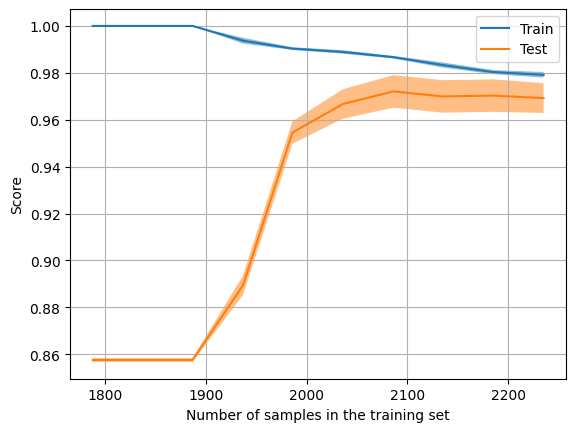

 *KNN model:
Recall: 0.8736842105263158 / Precision: 0.9431818181818182
Classification report:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       464
           1       0.94      0.87      0.91        95

    accuracy                           0.97       559
   macro avg       0.96      0.93      0.94       559
weighted avg       0.97      0.97      0.97       559

Confusion matrix:
[[459   5]
 [ 12  83]]
Confusion matrix on training set: 
[[1913   19]
 [  33  270]]



In [260]:
recall, precision, report, cmatrix, cmatrix_train = train_model(
    'KNN', X=df_cleaned['body'], y=df_cleaned['target'],plot_curve='yes'
    )
print(f"\033[1m *KNN model:\033[0m")
print(f"Recall: {recall} / Precision: {precision}")
print(f"Classification report:\n{report}")
print(f"Confusion matrix:\n{cmatrix}")
print(f"Confusion matrix on training set: \n{cmatrix_train}\n")